In [ ]:
%pip install pandas geopandas folium matplotlib seaborn shapely

C:\Users\ASUS\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


=== ANÁLISIS GEOESPACIAL DE HOSPITALES PÚBLICOS EN PERÚ ===
🚀 INICIANDO ANÁLISIS COMPLETO...

FASE 1: CARGA DE DATOS

1. Cargando datos IPRESS...
   - Operacionales: 20800
   - Solo públicos: 8813
   - Solo hospitales generales/especializados: 268

   Procesando coordenadas...
   Coordenadas válidas estándar: 0
   Coordenadas válidas intercambiadas: 241
   → Intercambiando coordenadas: NORTE->lon, ESTE->lat
   ✓ Hospitales públicos válidos: 241

2. Cargando shapefile de distritos...
   ✓ Distritos cargados: 1873
   Columnas disponibles: ['IDDPTO', 'DEPARTAMEN', 'IDPROV', 'PROVINCIA', 'IDDIST', 'DISTRITO', 'CAPITAL', 'CODCCPP', 'AREA', 'FUENTE', 'geometry']

📊 RESUMEN DE DATOS CARGADOS:
   • Hospitales públicos válidos: 241
   • Departamentos: 25
   • Distritos: 175

FASE 2: MAPAS ESTÁTICOS (TASK 1)

=== TASK 1: MAPAS ESTÁTICOS ===
   Usando columna de distrito: DISTRITO
   Realizando spatial join...
   Distritos con hospitales: 175
   Distritos con hospitales > 0: 212
   Máximo hospita

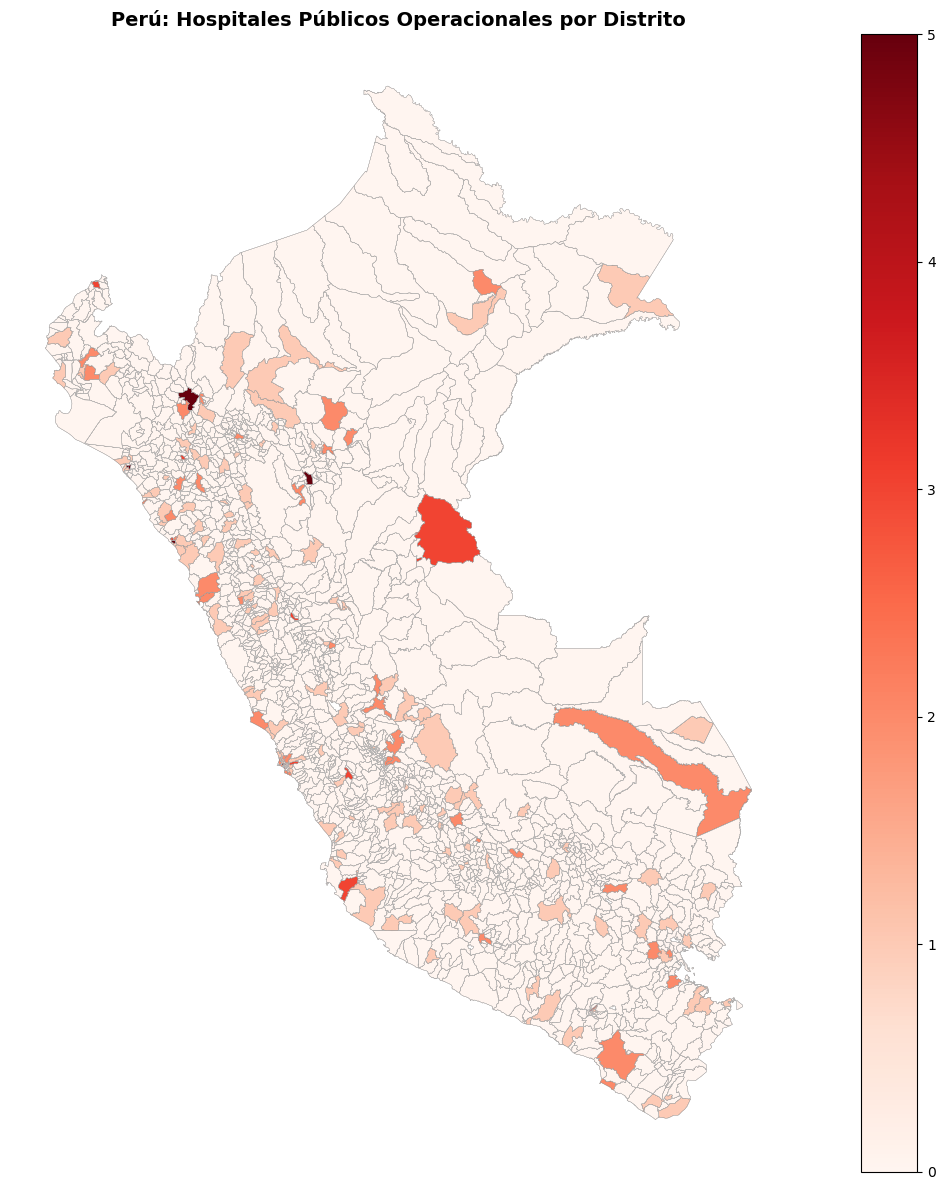

   Creando Mapa 2: Distritos sin hospitales


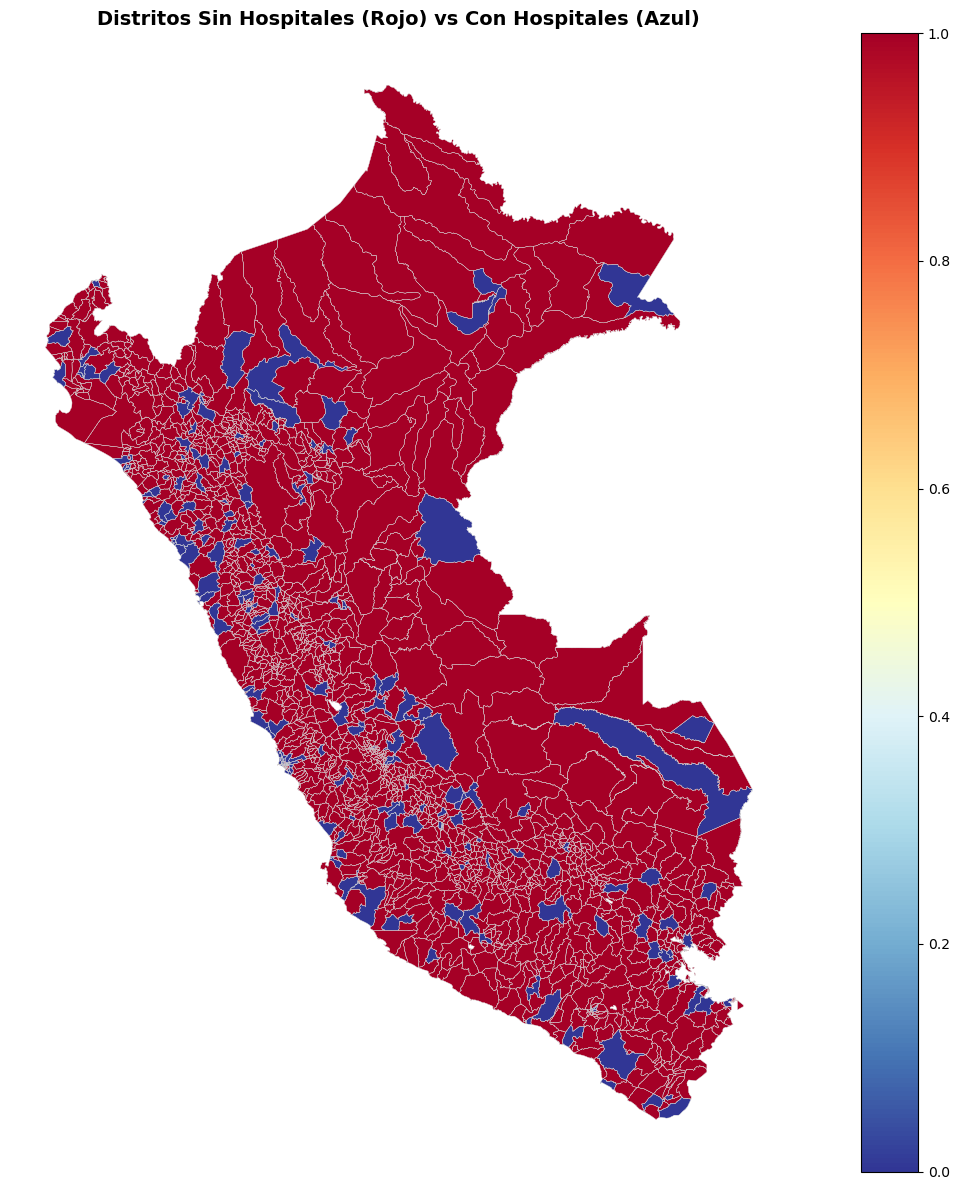

   Creando Mapa 3: Top 10 distritos


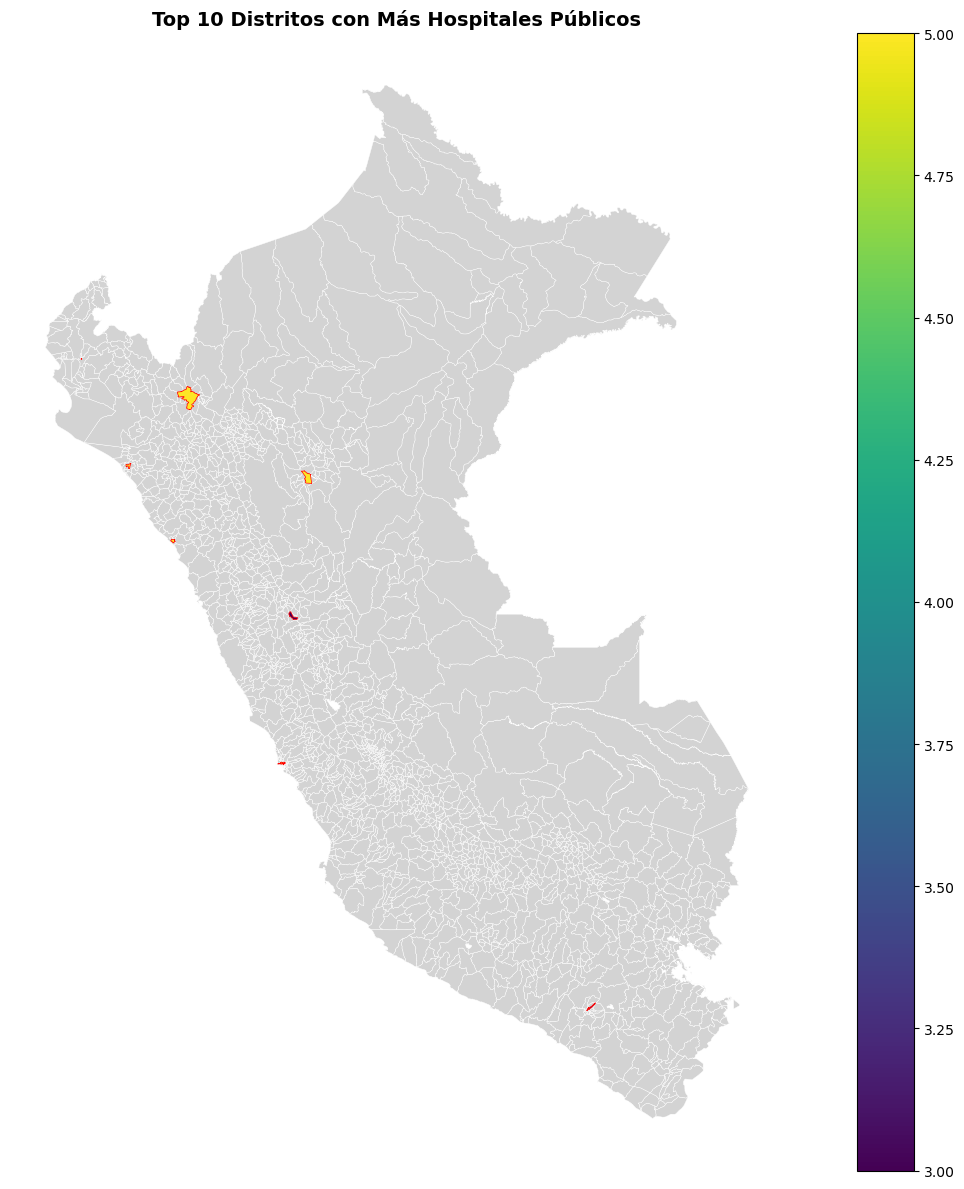

   ✅ Mapas estáticos completados

FASE 3: ANÁLISIS DEPARTAMENTAL (TASK 2)

=== TASK 2: ANÁLISIS DEPARTAMENTAL ===
   Departamento con MÁS hospitales: LIMA (42)
   Departamento con MENOS hospitales: TACNA (2)
   ✅ Tabla guardada: C:\Users\ASUS\OneDrive - Universidad del Pacífico\Tareas Data Science\Hospitals-Access-Peru\Output\resumen_departamentos.csv


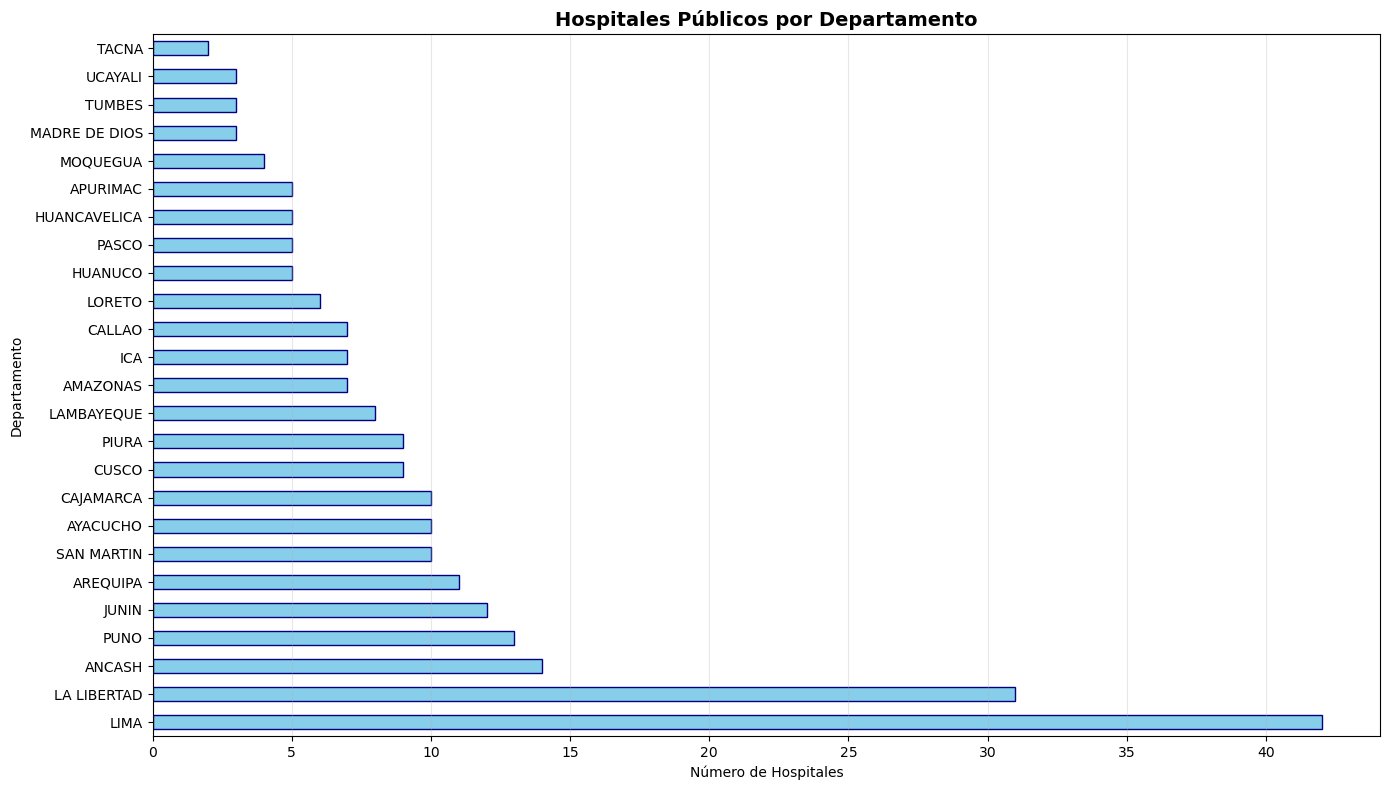

   ✅ Gráfico guardado: C:\Users\ASUS\OneDrive - Universidad del Pacífico\Tareas Data Science\Hospitals-Access-Peru\Output\grafico_departamentos.png

FASE 4: ANÁLISIS DE PROXIMIDAD (TASK 3)

=== TASK 3: ANÁLISIS DE PROXIMIDAD ===

   Analizando LIMA...
   Hospitales en LIMA: 42
   🔴 Zona aislada: LURIGANCHO (1 hospitales en 10km)
   🟢 Zona concentrada: LIMA (20 hospitales en 10km)
   ✅ Mapa guardado: C:\Users\ASUS\OneDrive - Universidad del Pacífico\Tareas Data Science\Hospitals-Access-Peru\Output\mapa_proximidad_lima.html

   Analizando LORETO...
   Hospitales en LORETO: 6
   🔴 Zona aislada: RAMON CASTILLA (1 hospitales en 10km)
   🟢 Zona concentrada: IQUITOS (3 hospitales en 10km)
   ✅ Mapa guardado: C:\Users\ASUS\OneDrive - Universidad del Pacífico\Tareas Data Science\Hospitals-Access-Peru\Output\mapa_proximidad_loreto.html

FASE 5: MAPA NACIONAL INTERACTIVO

=== MAPA NACIONAL INTERACTIVO ===
   ✅ Mapa nacional guardado: C:\Users\ASUS\OneDrive - Universidad del Pacífico\Tareas Data S

In [3]:

import pandas as pd
import geopandas as gpd
import folium
from folium.plugins import MarkerCluster
import matplotlib.pyplot as plt
import numpy as np
import os
from shapely.geometry import Point
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

# =============================================================================
# CONFIGURACIÓN DE RUTAS
# =============================================================================
INPUT_PATH = r"C:\Users\ASUS\OneDrive - Universidad del Pacífico\Tareas Data Science\Hospitals-Access-Peru\Input"
OUTPUT_PATH = r"C:\Users\ASUS\OneDrive - Universidad del Pacífico\Tareas Data Science\Hospitals-Access-Peru\Output"
os.makedirs(OUTPUT_PATH, exist_ok=True)

print("=== ANÁLISIS GEOESPACIAL DE HOSPITALES PÚBLICOS EN PERÚ ===")

# =============================================================================
# 1. CARGA Y PROCESAMIENTO DE DATOS (Basado en código original)
# =============================================================================

def load_hospitals_data():
    """
    Carga y procesa datos de hospitales manteniendo la lógica original
    Aplica filtros específicos para hospitales públicos operacionales
    """
    print("\n1. Cargando datos IPRESS...")
    
    csv_file = os.path.join(INPUT_PATH, "IPRESS.csv")
    
    # Cargar con diferentes encodings (del código original)
    df = None
    for encoding in ['utf-8', 'latin-1', 'cp1252']:
        try:
            df = pd.read_csv(csv_file, encoding=encoding)
            break
        except:
            continue
    
    if df is None:
        raise FileNotFoundError(f"No se pudo cargar {csv_file}")
    
    
    # FILTROS ESPECÍFICOS
    
    # 1. Filtrar por condición EN FUNCIONAMIENTO
    if 'Condición' in df.columns:
        df = df[df['Condición'].str.contains('EN FUNCIONAMIENTO', case=False, na=False)]
        print(f"   - Operacionales: {len(df)}")
    
    # 2. Filtrar por institución (solo públicos)
    if 'Institución' in df.columns:
        df = df[~df['Institución'].isin(['PRIVADO', 'OTRO'])]
        print(f"   - Solo públicos: {len(df)}")
    
    # 3. Filtrar por clasificación (solo hospitales generales y especializados)
    if 'Clasificación' in df.columns:
        clasificaciones_validas = [
            'HOSPITALES O CLINICAS DE ATENCION GENERAL',
            'HOSPITALES O CLINICAS DE ATENCION ESPECIALIZADA'
        ]
        df = df[df['Clasificación'].isin(clasificaciones_validas)]
        print(f"   - Solo hospitales generales/especializados: {len(df)}")
    
    # Procesamiento de coordenadas (manteniendo lógica original)
    print("\n   Procesando coordenadas...")
    
    # Verificar columnas de coordenadas
    coord_cols = ['NORTE', 'ESTE']
    for col in coord_cols:
        if col not in df.columns:
            print(f"   ERROR: No se encuentra columna {col}")
            return None
    
    # Limpiar datos nulos y vacíos
    df = df.dropna(subset=['NORTE', 'ESTE'])
    df = df[(df['NORTE'] != '') & (df['ESTE'] != '')]
    
    # Función para convertir coordenadas de forma segura (del código original)
    def to_numeric_safe(series):
        return pd.to_numeric(
            series.astype(str).str.replace(',', '.').str.replace(' ', ''),
            errors='coerce'
        )
    
    # Convertir a numérico
    df['NORTE'] = to_numeric_safe(df['NORTE'])
    df['ESTE'] = to_numeric_safe(df['ESTE'])
    
    # Eliminar NaN después de conversión
    df = df.dropna(subset=['NORTE', 'ESTE'])
    
    # Aplicar lógica de corrección de coordenadas del código original
    # Verificar rangos válidos para Perú
    valid_standard = (
        (df['ESTE'].between(-81.5, -68.5)) & 
        (df['NORTE'].between(-18.5, 0))
    ).sum()
    
    valid_swapped = (
        (df['NORTE'].between(-81.5, -68.5)) & 
        (df['ESTE'].between(-18.5, 0))
    ).sum()
    
    print(f"   Coordenadas válidas estándar: {valid_standard}")
    print(f"   Coordenadas válidas intercambiadas: {valid_swapped}")
    
    # Usar interpretación que dé más puntos válidos (lógica original)
    if valid_swapped > valid_standard:
        print("   → Intercambiando coordenadas: NORTE->lon, ESTE->lat")
        df['lon'] = df['NORTE']
        df['lat'] = df['ESTE']
    else:
        print("   → Usando coordenadas estándar: ESTE->lon, NORTE->lat")
        df['lon'] = df['ESTE'] 
        df['lat'] = df['NORTE']
    
    # Filtrar puntos válidos en territorio peruano
    df_peru = df[
        (df['lat'].between(-18.5, 0)) & 
        (df['lon'].between(-81.5, -68.5))
    ].copy()
    
    print(f"   ✓ Hospitales públicos válidos: {len(df_peru)}")
    
    # Crear GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df_peru,
        geometry=gpd.points_from_xy(df_peru['lon'], df_peru['lat']),
        crs='EPSG:4326'
    )
    
    return gdf

def load_districts_shapefile():
    """
    Cargar shapefile de distritos manteniendo estructura original
    """
    print("\n2. Cargando shapefile de distritos...")
    
    shp_path = os.path.join(INPUT_PATH, 'shape_file', 'DISTRITOS.shp')
    
    if not os.path.exists(shp_path):
        print(f"   ERROR: No se encuentra {shp_path}")
        return None
    
    districts = gpd.read_file(shp_path)
    
    # Asegurar CRS correcto
    if districts.crs is None:
        districts = districts.set_crs('EPSG:4326')
    else:
        districts = districts.to_crs('EPSG:4326')
    
    print(f"   ✓ Distritos cargados: {len(districts)}")
    print(f"   Columnas disponibles: {list(districts.columns)}")
    
    return districts

# =============================================================================
# TASK 1: MAPAS ESTÁTICOS CON GEOPANDAS (Manteniendo lógica original)
# =============================================================================

def create_static_maps(hospitals_gdf, districts_gdf):
    """
    Crear mapas estáticos usando la lógica que funcionaba en el código original
    """
    print("\n=== TASK 1: MAPAS ESTÁTICOS ===")
    
    if districts_gdf is None:
        print("No se pudo")
        return
    
    # Encontrar columna correcta para distrito en el shapefile
    distrito_col = None
    for col in ['DISTRITO', 'NOMBDIST', 'NOMBRE', 'IDDIST']:
        if col in districts_gdf.columns:
            distrito_col = col
            break
    
    if not distrito_col:
        print(f"   Columnas disponibles: {list(districts_gdf.columns)}")
        return
    
    print(f"   Usando columna de distrito: {distrito_col}")
    
    # Contar hospitales por distrito usando spatial join (lógica original)
    print("   Realizando spatial join...")
    hospitals_with_district = gpd.sjoin(hospitals_gdf, districts_gdf, how='left', predicate='within')
    
    # Contar por distrito
    conteo = hospitals_with_district.groupby(distrito_col).size().reset_index(name='Total_Hospitales')
    print(f"   Distritos con hospitales: {len(conteo)}")
    
    # Hacer merge con shapefile
    gdf_plot = districts_gdf.merge(conteo, left_on=distrito_col, right_on=distrito_col, how='left')
    gdf_plot['Total_Hospitales'] = gdf_plot['Total_Hospitales'].fillna(0).astype(int)
    
    print(f"   Distritos con hospitales > 0: {(gdf_plot['Total_Hospitales'] > 0).sum()}")
    print(f"   Máximo hospitales por distrito: {gdf_plot['Total_Hospitales'].max()}")
    
    # MAPA 1: Total hospitales por distrito
    print("   Creando Mapa 1: Total por distrito")
    fig, ax = plt.subplots(figsize=(15, 12))
    
    # Bordes base
    districts_gdf.boundary.plot(ax=ax, color='#c9c9c9', linewidth=0.2)
    
    # Coroplético con esquema de clasificación
    try:
        gdf_plot.plot(
            ax=ax,
            column='Total_Hospitales',
            cmap='Reds',
            scheme='Quantiles',
            k=7,
            linewidth=0.15,
            edgecolor='black',
            legend=True
        )
    except:
        # Fallback sin esquema si no está disponible
        gdf_plot.plot(
            ax=ax,
            column='Total_Hospitales',
            cmap='Reds',
            linewidth=0.15,
            edgecolor='black',
            legend=True
        )
    
    ax.set_title('Perú: Hospitales Públicos Operacionales por Distrito', fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'mapa1_hospitales_distrito.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # MAPA 2: Distritos sin hospitales
    print("   Creando Mapa 2: Distritos sin hospitales")
    fig, ax = plt.subplots(figsize=(15, 12))
    
    districts_gdf.boundary.plot(ax=ax, color='#c9c9c9', linewidth=0.2)
    
    gdf_plot['sin_hospitales'] = (gdf_plot['Total_Hospitales'] == 0).astype(int)
    gdf_plot.plot(
        ax=ax,
        column='sin_hospitales',
        cmap='RdYlBu_r',
        linewidth=0.15,
        edgecolor='white',
        legend=True
    )
    
    ax.set_title('Distritos Sin Hospitales (Rojo) vs Con Hospitales (Azul)', fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'mapa2_distritos_sin_hospitales.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    # MAPA 3: Top 10 distritos
    print("   Creando Mapa 3: Top 10 distritos")
    fig, ax = plt.subplots(figsize=(15, 12))
    
    # Base gris
    districts_gdf.plot(color='lightgray', ax=ax, edgecolor='white', linewidth=0.3)
    
    # Resaltar top 10
    top10 = gdf_plot.nlargest(10, 'Total_Hospitales')
    top10.plot(
        ax=ax,
        column='Total_Hospitales',
        cmap='viridis',
        linewidth=0.5,
        edgecolor='red',
        legend=True
    )
    
    ax.set_title('Top 10 Distritos con Más Hospitales Públicos', fontsize=14, fontweight='bold')
    ax.axis('off')
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_PATH, 'mapa3_top10_distritos.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("   ✅ Mapas estáticos completados")
    return gdf_plot

# =============================================================================
# TASK 2: ANÁLISIS DEPARTAMENTAL
# =============================================================================

def analyze_departments(hospitals_gdf):
    """
    Análisis por departamento
    """
    print("\n=== TASK 2: ANÁLISIS DEPARTAMENTAL ===")
    
    # Conteo por departamento
    dept_counts = hospitals_gdf.groupby('Departamento').size().sort_values(ascending=False)
    
    print(f"   Departamento con MÁS hospitales: {dept_counts.index[0]} ({dept_counts.iloc[0]})")
    print(f"   Departamento con MENOS hospitales: {dept_counts.index[-1]} ({dept_counts.iloc[-1]})")
    
    # Crear tabla resumen
    dept_df = dept_counts.to_frame('Total_Hospitales')
    dept_df['Porcentaje'] = (dept_df['Total_Hospitales'] / dept_df['Total_Hospitales'].sum() * 100).round(2)
    
    # Guardar tabla
    csv_path = os.path.join(OUTPUT_PATH, 'resumen_departamentos.csv')
    dept_df.to_csv(csv_path)
    print(f"   ✅ Tabla guardada: {csv_path}")
    
    # Crear gráfico de barras
    fig, ax = plt.subplots(figsize=(14, 8))
    dept_counts.plot(kind='barh', ax=ax, color='skyblue', edgecolor='navy')
    ax.set_title('Hospitales Públicos por Departamento', fontsize=14, fontweight='bold')
    ax.set_xlabel('Número de Hospitales')
    ax.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    
    graph_path = os.path.join(OUTPUT_PATH, 'grafico_departamentos.png')
    plt.savefig(graph_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"   ✅ Gráfico guardado: {graph_path}")
    
    return dept_counts

# =============================================================================
# TASK 3: ANÁLISIS DE PROXIMIDAD (Simplificado pero funcional)
# =============================================================================

def haversine_distance(lat1, lon1, lat2, lon2):
    """
    Calcular distancia haversine en kilómetros
    """
    R = 6371.0  # Radio de la Tierra en km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

def proximity_analysis_lima_loreto(hospitals_gdf):
    """
    Análisis de proximidad para Lima y Loreto
    Encuentra puntos de alta y baja concentración hospitalaria
    """
    print("\n=== TASK 3: ANÁLISIS DE PROXIMIDAD ===")
    
    for region in ['LIMA', 'LORETO']:
        print(f"\n   Analizando {region}...")
        
        # Filtrar hospitales de la región
        region_hospitals = hospitals_gdf[hospitals_gdf['Departamento'].str.upper() == region].copy()
        
        if len(region_hospitals) == 0:
            print(f"   ❌ No hay hospitales en {region}")
            continue
        
        print(f"   Hospitales en {region}: {len(region_hospitals)}")
        
        # Análisis por distrito para encontrar concentraciones
        distritos_stats = region_hospitals.groupby('Distrito').agg({
            'lat': 'mean',
            'lon': 'mean'
        }).reset_index()
        
        # Para cada distrito, contar hospitales en radio de 10km
        distrito_counts = []
        for _, distrito in distritos_stats.iterrows():
            # Calcular distancias a todos los hospitales de la región
            distances = region_hospitals.apply(
                lambda row: haversine_distance(
                    distrito['lat'], distrito['lon'],
                    row['lat'], row['lon']
                ), axis=1
            )
            
            # Contar hospitales dentro de 10km
            hospitals_10km = (distances <= 10).sum()
            
            distrito_counts.append({
                'distrito': distrito['Distrito'],
                'lat': distrito['lat'],
                'lon': distrito['lon'],
                'hospitales_10km': hospitals_10km
            })
        
        if not distrito_counts:
            continue
        
        distrito_counts_df = pd.DataFrame(distrito_counts)
        
        # Encontrar extremos
        min_idx = distrito_counts_df['hospitales_10km'].idxmin()
        max_idx = distrito_counts_df['hospitales_10km'].idxmax()
        
        punto_aislado = distrito_counts_df.loc[min_idx]
        punto_concentrado = distrito_counts_df.loc[max_idx]
        
        print(f"   🔴 Zona aislada: {punto_aislado['distrito']} ({punto_aislado['hospitales_10km']} hospitales en 10km)")
        print(f"   🟢 Zona concentrada: {punto_concentrado['distrito']} ({punto_concentrado['hospitales_10km']} hospitales en 10km)")
        
        # Crear mapa interactivo estilo imagen de referencia
        center_lat = region_hospitals['lat'].mean()
        center_lon = region_hospitals['lon'].mean()
        
        # Mapa base
        m = folium.Map(
            location=[center_lat, center_lon], 
            zoom_start=7,
            tiles='CartoDB positron'  # Fondo claro como en la imagen
        )
        
        # Círculo ROJO para zona aislada (menor concentración)
        folium.Circle(
            location=[punto_aislado['lat'], punto_aislado['lon']],
            radius=10000,  # 10km en metros
            color='red',
            fill=True,
            fillColor='red',
            fillOpacity=0.3,
            weight=2,
            popup=f"<b>Zona Aislada</b><br>"
                  f"Distrito: {punto_aislado['distrito']}<br>"
                  f"Hospitales en 10km: {punto_aislado['hospitales_10km']}"
        ).add_to(m)
        
        # Círculo VERDE para zona concentrada (mayor concentración)
        folium.Circle(
            location=[punto_concentrado['lat'], punto_concentrado['lon']],
            radius=10000,  # 10km en metros
            color='green',
            fill=True,
            fillColor='green',
            fillOpacity=0.3,
            weight=2,
            popup=f"<b>Zona Concentrada</b><br>"
                  f"Distrito: {punto_concentrado['distrito']}<br>"
                  f"Hospitales en 10km: {punto_concentrado['hospitales_10km']}"
        ).add_to(m)
        
        # Marcadores centrales
        folium.Marker(
            [punto_aislado['lat'], punto_aislado['lon']],
            popup=f"<b>Zona Aislada</b><br>{punto_aislado['distrito']}",
            icon=folium.Icon(color='red', icon='exclamation-sign')
        ).add_to(m)
        
        folium.Marker(
            [punto_concentrado['lat'], punto_concentrado['lon']],
            popup=f"<b>Zona Concentrada</b><br>{punto_concentrado['distrito']}",
            icon=folium.Icon(color='green', icon='info-sign')
        ).add_to(m)
        
        # Cluster de todos los hospitales de la región
        hospital_cluster = MarkerCluster(name=f'Hospitales {region}')
        for _, hospital in region_hospitals.iterrows():
            folium.Marker(
                [hospital['lat'], hospital['lon']],
                popup=f"<b>{hospital.get('Nombre del establecimiento', 'Hospital')}</b><br>"
                      f"Distrito: {hospital.get('Distrito', 'N/A')}<br>"
                      f"Institución: {hospital.get('Institución', 'N/A')}",
                icon=folium.Icon(color='blue', icon='plus-sign', prefix='fa')
            ).add_to(hospital_cluster)
        
        hospital_cluster.add_to(m)
        
        # Control de capas
        folium.LayerControl().add_to(m)
        
        # Guardar mapa
        map_path = os.path.join(OUTPUT_PATH, f'mapa_proximidad_{region.lower()}.html')
        m.save(map_path)
        print(f"   ✅ Mapa guardado: {map_path}")

# =============================================================================
# MAPA NACIONAL INTERACTIVO
# =============================================================================

def create_national_interactive_map(hospitals_gdf, districts_gdf):
    """
    Crear mapa nacional coroplético con cluster de hospitales
    """
    print("\n=== MAPA NACIONAL INTERACTIVO ===")
    
    # Centro de Perú
    m = folium.Map(
        location=[-9.19, -75.02], 
        zoom_start=6,
        tiles='OpenStreetMap'
    )
    
    # Si hay shapefile, crear coroplético
    if districts_gdf is not None:
        # Spatial join y conteo
        hospitals_with_district = gpd.sjoin(hospitals_gdf, districts_gdf, how='left', predicate='within')
        
        # Encontrar columna de distrito
        distrito_col = None
        for col in ['DISTRITO', 'NOMBDIST', 'NOMBRE', 'IDDIST']:
            if col in districts_gdf.columns:
                distrito_col = col
                break
        
        if distrito_col:
            conteo = hospitals_with_district.groupby(distrito_col).size().reset_index(name='count')
            districts_merged = districts_gdf.merge(conteo, left_on=distrito_col, right_on=distrito_col, how='left')
            districts_merged['count'] = districts_merged['count'].fillna(0)
            
            # Agregar coroplético
            folium.Choropleth(
                geo_data=districts_merged,
                data=districts_merged,
                columns=[distrito_col, 'count'],
                key_on=f'feature.properties.{distrito_col}',
                fill_color='YlOrRd',
                fill_opacity=0.7,
                line_opacity=0.2,
                legend_name='Hospitales Públicos por Distrito'
            ).add_to(m)
    
    # Cluster de hospitales por departamento
    departments = hospitals_gdf['Departamento'].unique()
    
    for dept in departments:
        if pd.isna(dept):
            continue
        
        dept_hospitals = hospitals_gdf[hospitals_gdf['Departamento'] == dept]
        dept_cluster = MarkerCluster(name=f'Hospitales {dept}')
        
        for _, hospital in dept_hospitals.iterrows():
            folium.Marker(
                [hospital['lat'], hospital['lon']],
                popup=f"<b>{hospital.get('Nombre del establecimiento', 'Hospital')}</b><br>"
                      f"Departamento: {dept}<br>"
                      f"Distrito: {hospital.get('Distrito', 'N/A')}<br>"
                      f"Clasificación: {hospital.get('Clasificación', 'N/A')}",
                icon=folium.Icon(color='red', icon='plus-sign', prefix='fa')
            ).add_to(dept_cluster)
        
        dept_cluster.add_to(m)
    
    # Estadísticas en el mapa
    total_hospitals = len(hospitals_gdf)
    total_departments = hospitals_gdf['Departamento'].nunique()
    
    stats_html = f'''
    <div style="position: fixed; top: 10px; right: 10px; width: 250px; height: 120px; 
                background-color: white; border:2px solid grey; z-index:9999; 
                font-size:14px; padding: 10px; border-radius: 5px;">
    <h4 style="margin-top: 0;">📊 Estadísticas</h4>
    <p><b>Total Hospitales Públicos:</b> {total_hospitals}</p>
    <p><b>Departamentos:</b> {total_departments}</p>
    <p><b>Solo operacionales y especializados</b></p>
    </div>
    '''
    m.get_root().html.add_child(folium.Element(stats_html))
    
    # Control de capas
    folium.LayerControl().add_to(m)
    
    # Guardar
    national_path = os.path.join(OUTPUT_PATH, 'mapa_nacional_coropletico.html')
    m.save(national_path)
    print(f"   ✅ Mapa nacional guardado: {national_path}")

# =============================================================================
# FUNCIÓN PRINCIPAL
# =============================================================================

def main():
    """
    Ejecutar análisis completo manteniendo lógica funcional del código original
    """
    try:
        print("🚀 INICIANDO ANÁLISIS COMPLETO...")
        
        # 1. Cargar y procesar datos
        print("\n" + "="*50)
        print("FASE 1: CARGA DE DATOS")
        print("="*50)
        
        hospitals_gdf = load_hospitals_data()
        if hospitals_gdf is None or len(hospitals_gdf) == 0:
            print("❌ ERROR: No se pudieron cargar datos de hospitales")
            return
        
        districts_gdf = load_districts_shapefile()
        
        # Mostrar resumen de datos cargados
        print(f"\n📊 RESUMEN DE DATOS CARGADOS:")
        print(f"   • Hospitales públicos válidos: {len(hospitals_gdf)}")
        print(f"   • Departamentos: {hospitals_gdf['Departamento'].nunique()}")
        print(f"   • Distritos: {hospitals_gdf['Distrito'].nunique()}")
        
        # 2. Crear mapas estáticos
        print("\n" + "="*50)
        print("FASE 2: MAPAS ESTÁTICOS (TASK 1)")
        print("="*50)
        
        districts_with_counts = create_static_maps(hospitals_gdf, districts_gdf)
        
        # 3. Análisis departamental
        print("\n" + "="*50)
        print("FASE 3: ANÁLISIS DEPARTAMENTAL (TASK 2)")
        print("="*50)
        
        dept_analysis = analyze_departments(hospitals_gdf)
        
        # 4. Análisis de proximidad
        print("\n" + "="*50)
        print("FASE 4: ANÁLISIS DE PROXIMIDAD (TASK 3)")
        print("="*50)
        
        proximity_analysis_lima_loreto(hospitals_gdf)
        
        # 5. Mapa nacional interactivo
        print("\n" + "="*50)
        print("FASE 5: MAPA NACIONAL INTERACTIVO")
        print("="*50)
        
        create_national_interactive_map(hospitals_gdf, districts_gdf)
        
        
        
        
    except Exception as e:
        print(f"\n❌ ERROR DURANTE LA EJECUCIÓN:")
        print(f"   {str(e)}")
        print(f"\n🔍 DETALLES DEL ERROR:")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()